# Processing scRNA-seq data with Seurat
# MCF7 case study

###### Prepared by Zeynep Kalender Atak & adapted by katina spanier [katina.spanier@kuleuven.vib.be]

---

We will be using the [Seurat](http://satijalab.org/seurat/) package from the Satija Lab, but you can check these additional resources for more analysis methods and tutorials: 

* [Single cell analysis course](https://hemberg-lab.github.io/scRNA.seq.course/index.html) by Martin Hemberg and collaborators.
* [ASAP:](https://asap.epfl.ch)  Automated Single-cell Analysis Pipeline
* [Awesome single-cell repository](https://github.com/linnarsson-lab/awesome-single-cell) by Sten Linnarson 
* [scRNA tools](https://www.scrna-tools.org) by Alicia Oshlack 

---
Recommended reading: 

[Identifying cell populations with scRNASeq](https://www.sciencedirect.com/science/article/pii/S0098299717300493): An easy-to-read review on single-cell sequencing technologies, methodologies and computational pipelines. 

--- 
Find single-cell RNA-seq data online:
* you can look for data in GEO or in ArrayExpress
* look for (interesting) scRNA-seq papers and check the *Data availability* section to reach the raw data 
* [10X Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets) makes a number of scRNA-seq data freely accessible 
* the UCSC cell browser offers a few scRNA-seq data sets
* the Human Cell Atlas
---

#### Outline
Part I: MCF7 case study

With this case study, you will get familiar with scRNA-seq data and be able to perform basic analysis (normalization, clustering and marker gene discovery). 

# MCF7 case study

For this analysis, we will be using the single cell expression dataset on MCF7 cells (a breast cancer cell line) with and without Nutlin treatment. This is the same biological setup as the bulk RNA-seq analysis: we stimulate p53 expression using Nutlin.

The data were generated in the Aerts lab using the Drop-seq technology.

### Prepare your workspace

Make sure set your working directory to a place where you have enough space to save large data.

In R, you do that with the `setwd` command (analogous `cd` in bash).

In [1]:
setwd(path.expand("~/data/jupyternotebooks/"))

Create a folder for this session. You can do that with `dir.create` command in R.

In [2]:
dir.create("scRNAseq")

Warning message in dir.create("scRNAseq"):
“'scRNAseq' already exists”

If the directory is already there, it won't create it (again) and will give a warning.

In [3]:
setwd("scRNAseq")

You can check which directory you are in using the comman `getwd` (analogous to the `pwd` command of bash).

In [4]:
getwd()

[1] "/mnt/storage/u0038182/jupyternotebooks/scRNAseq"

After setting up your working directory, you can start.

### Load libraries

Load some R packages that help you to analyze single cell RNA-Seq data.

In [5]:
options(stringsAsFactors=FALSE)

library(Seurat)
library(dplyr)
library(Matrix)
library(SCopeLoomR)
library(IRdisplay)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘SCopeLoomR’

The following object is masked from ‘package:base’:

    flush



### Load the raw data

In this case, the rawdata is a count matrix (with rows representing genes and columns representing cells). 

In [6]:
rawfile <- '/mnt/storage/data/dropseq/MCF7_nutlin_dropseq_raw.tsv'
rawcounts <- read.table(rawfile, sep="\t", header=1, row.names = 1)

In [7]:
#inspect the top left corner of the expression matrix
rawcounts[1:5,1:5]

,CTCTCCCATCTN_BL,GCCTGGCCTTTT_BL,CTGGTTTGCCCC_BL,AGTCATTTACAC_BL,ACCACCATCATN_BL
,<int>,<int>,<int>,<int>,<int>
7SK,0,0,0,0,0
A1BG,1,0,0,0,0
A1BG-AS1,1,1,3,2,1
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,1


In [8]:
#inspect the top right corner of the expression matrix
rawcounts[1:5,(ncol(rawcounts)-5):ncol(rawcounts)]

,ACCAGTCAGGCA_Nutlin,CCCGCCCAGGTG_Nutlin,CAGTTTAAAGAT_Nutlin,CTGCCCGTCATA_Nutlin,CTGTGCAGCCCC_Nutlin,GATCTCATTTAG_Nutlin
,<int>,<int>,<int>,<int>,<int>,<int>
7SK,0,0,0,0,0,0
A1BG,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,0
A2M-AS1,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0


In [9]:
dim(rawcounts)

[1] 19412  3307

There are 19412 genes (rows), and 3307 cells (columns).

You may have noticed that the columns contain a subscript. Cells with the subscript `_BL` are the untreated cells, `_Nutlin` means that these cells underwent Nutlin treatment. To use this information later, we need to extract it. We do this by splitting the column names into two parts on the '`_`' delimiter, and store the cell-treatment assignments in the data frame object '`treatment`'.

In [10]:
treatment <- t(as.data.frame(strsplit(colnames(rawcounts),'_')))[,2]
names(treatment) <- colnames(rawcounts)
names(treatment) <- colnames(rawcounts)

In [11]:
treatment <- as.factor(treatment)
table(treatment)

treatment
    BL Nutlin 
  1010   2297 

### Create a Seurat object

A Seurat object will contain all data related to this analysis. Especially with large data sets it is advisable to reduce the data set to high quality observations. We here exclude genes that are expressed in less than 20 cells, and cells that express less than 500 genes.

In [12]:
mcf7_seurat_obj <- CreateSeuratObject(rawcounts, min.cells = 20, min.features = 500)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [13]:
#printing the object returns some information
mcf7_seurat_obj

An object of class Seurat 
13708 features across 1559 samples within 1 assay 
Active assay: RNA (13708 features)

Add a 'Treatment' column to the meta data with information from the sample group.

In [14]:
mcf7_seurat_obj <- AddMetaData(object = mcf7_seurat_obj, metadata = treatment, col.name = "Treatment")

In [15]:
head(mcf7_seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Treatment
,<fct>,<dbl>,<int>,<fct>
CTCTCCCATCTN_BL,SeuratProject,140226,9996,BL
GCCTGGCCTTTT_BL,SeuratProject,115441,9394,BL
CTGGTTTGCCCC_BL,SeuratProject,105526,9085,BL
AGTCATTTACAC_BL,SeuratProject,104190,9195,BL
ACCACCATCATN_BL,SeuratProject,80150,8436,BL
ATAACCAGTTTA_BL,SeuratProject,76470,8609,BL


### Quality control & Filtering

While the `CreateSeuratObject` command imposes a basic minimum gene-cutoff, it does not filter out cells based on technical or biological parameters. One of the sources of technical bias is the presence of doublets: depending on the platform there is a chance that the observed counts are actually coming from a doublet and not a single cell. By visualizing gene and molecule counts, we can try to exclude cells with a clear outlier number of genes as potential doublets (or multiplets). 
The number of genes and UMIs (nFeature_RNA and nCount_RNA) are automatically calculated for every object by Seurat.

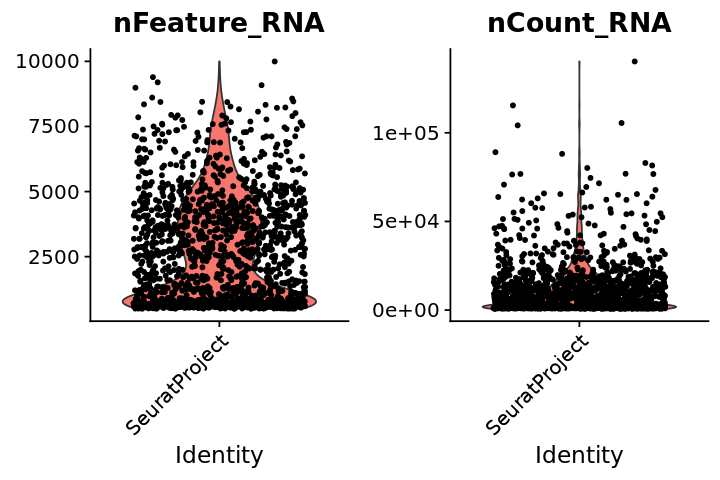

In [16]:
options(repr.plot.width=6, repr.plot.height=4)
VlnPlot(object = mcf7_seurat_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

In [17]:
summary(mcf7_seurat_obj@meta.data$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  496.0   769.5  2470.0  2759.1  4252.0  9996.0 

In [18]:
summary(mcf7_seurat_obj@meta.data$nCount_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    726    1398    6263   11386   15783  140226 

We can also visualize these metrics in relation to covariates of our experimental design (in this case we have one covariate, the `Treatment`). 

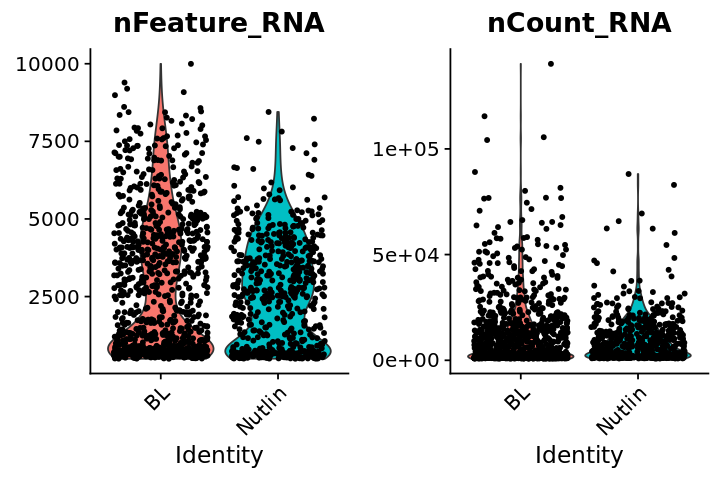

In [19]:
options(repr.plot.width=6, repr.plot.height=4)
VlnPlot(object = mcf7_seurat_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, group.by = "Treatment")

It is also common practice to use mitochondrial gene counts for quality control. Citing from [Simple Single Cell](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) workflows (Lun, McCarthy & Marioni, 2017):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

To this end, we first add the percentage of mitochondrial reads for each cell to the meta data:

In [20]:
# The [[ operator can add columns to object metadata.
mcf7_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(mcf7_seurat_obj, pattern = "^MT-")

In [21]:
head(mcf7_seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Treatment,percent.mt
,<fct>,<dbl>,<int>,<fct>,<dbl>
CTCTCCCATCTN_BL,SeuratProject,140226,9996,BL,6.396817
GCCTGGCCTTTT_BL,SeuratProject,115441,9394,BL,4.908135
CTGGTTTGCCCC_BL,SeuratProject,105526,9085,BL,4.515475
AGTCATTTACAC_BL,SeuratProject,104190,9195,BL,5.223150
ACCACCATCATN_BL,SeuratProject,80150,8436,BL,7.796631
ATAACCAGTTTA_BL,SeuratProject,76470,8609,BL,7.787368


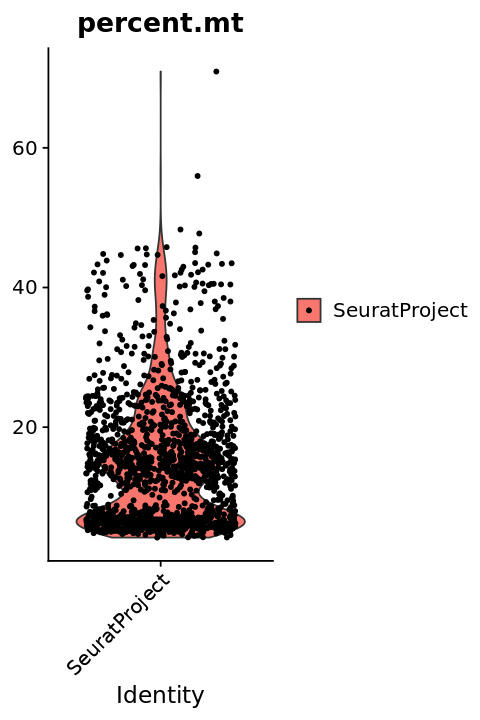

In [22]:
options(repr.plot.width=4, repr.plot.height=6)
VlnPlot(mcf7_seurat_obj, features = c("percent.mt"), ncol = 3)

What we observe in this violin plot is not a small number of cells with extreme values but a general dichotomy in terms of mitochondrial gene expression. We can check if this is related to `Treatment`. 

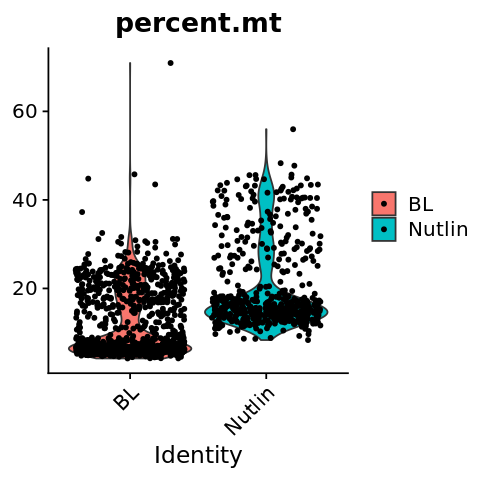

In [23]:
options(repr.plot.width=4, repr.plot.height=4)
VlnPlot(mcf7_seurat_obj, features = c("percent.mt"), group.by = "Treatment")

This might indeed be due to biology rather than technical bias, thus we don't do any filtering based on mitochondrial gene expression. 

`FeatureScatter` can also be used for identifying cells with high number of genes or UMIs.

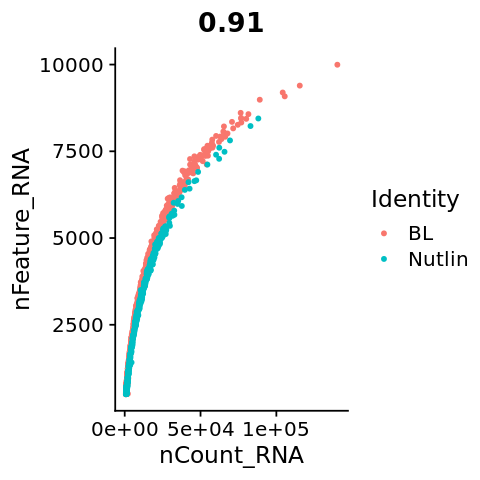

In [24]:
options(repr.plot.width=4, repr.plot.height=4)
FeatureScatter(object = mcf7_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "Treatment")

There seems to be a small number of cells that depart from the rest in terms of number of genes & UMIs. Thus we filter out cells that have less than 1500 genes (to filter out uninformative cells) and more than 75000 UMIs (to exclude possible doublets). 

In [25]:
mcf7_seurat_obj <- subset(mcf7_seurat_obj, subset = nFeature_RNA >= 1500 & nCount_RNA <= 75000)

In [26]:
mcf7_seurat_obj

An object of class Seurat 
13708 features across 916 samples within 1 assay 
Active assay: RNA (13708 features)

This cell-filtering decreases the number of cells from 1559 to 916.
Run `FeatureScatter` once more to have a look at the filtered data.

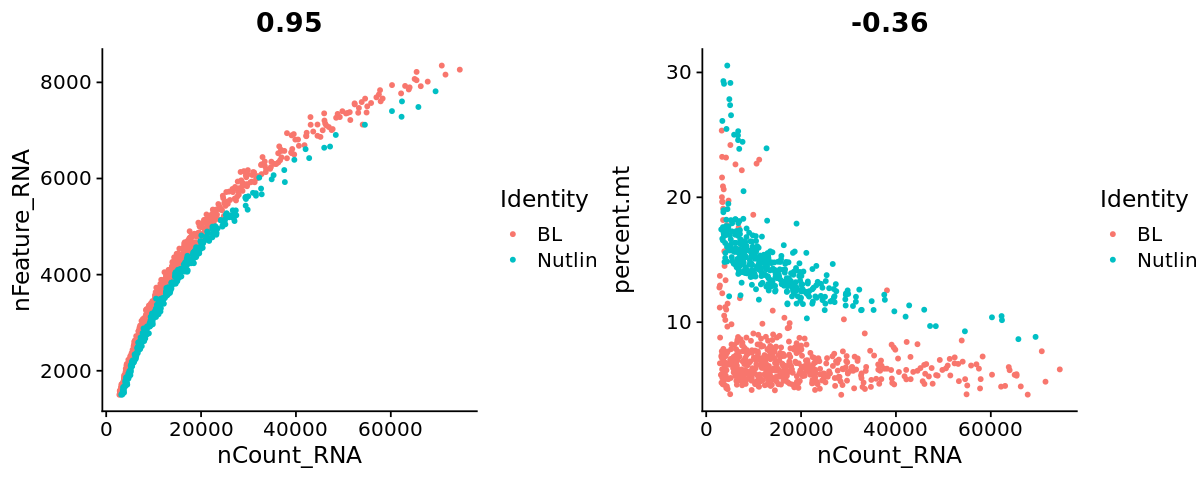

In [27]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- FeatureScatter(object = mcf7_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "Treatment")
plot2 <- FeatureScatter(object = mcf7_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt", group.by = "Treatment")

CombinePlots(plots = list(plot1, plot2))

### Normalizing the data 

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, Seurat employs a global-scaling normalization method “LogNormalize” that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [28]:
mcf7_seurat_obj <- NormalizeData(object = mcf7_seurat_obj, normalization.method = "LogNormalize")

Normalized values are stored in `mcf7_seurat_obj[["RNA"]]@data`:

In [29]:
mcf7_seurat_obj[["RNA"]]@data[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
         AGTATCACTATC_BL ATCTCTATGAGT_BL AGGGACCTTGAA_BL GCAGCTGGCACG_BL
A1BG-AS1       0.1322124       0.1258826       0.1422323       .        
A4GALT         0.2489684       .               .               0.1472921
AAAS           0.6878608       0.4295695       0.4770896       0.7470891
AACS           0.2489684       .               0.3774313       0.3893880
AADAT          0.2489684       .               0.2667308       .        
         CCGCCTACTTAA_BL
A1BG-AS1       .        
A4GALT         0.1308541
AAAS           0.4441767
AACS           .        
AADAT          0.2465498

While the original counts matrix is stored in `mcf7_seurat_obj[["RNA"]]@counts`:

In [30]:
mcf7_seurat_obj[["RNA"]]@counts[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
         AGTATCACTATC_BL ATCTCTATGAGT_BL AGGGACCTTGAA_BL GCAGCTGGCACG_BL
A1BG-AS1               1               1               1               .
A4GALT                 2               .               .               1
AAAS                   7               4               4               7
AACS                   2               .               3               3
AADAT                  2               .               2               .
         CCGCCTACTTAA_BL
A1BG-AS1               .
A4GALT                 1
AAAS                   4
AACS                   .
AADAT                  2

### Find variable genes

The vast majority of the genes in the dataset will contain little information, either because they did not change in the context of this experiment, or because they are very noisy. A common approach is to focus on the most variable genes in the dataset. Seurat does this with the `FindVariableGenes` function:

In [31]:
mcf7_seurat_obj <- FindVariableFeatures(object = mcf7_seurat_obj)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”When using repel, set xnudge and ynudge to 0 for optimal results


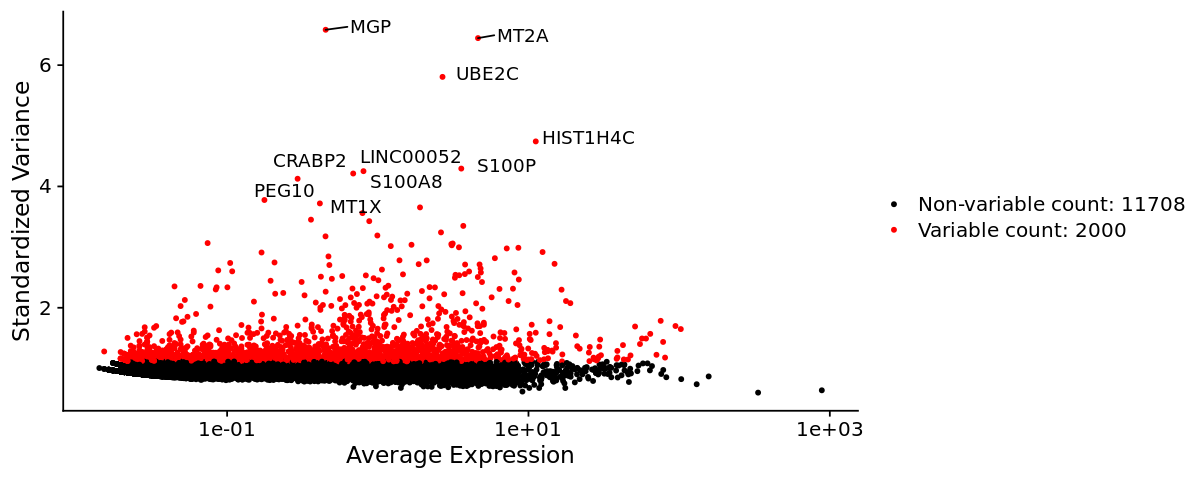

In [32]:
# Identify the 10 most variable genes
top10 <- head(VariableFeatures(mcf7_seurat_obj), 10)

# plot variable features
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- VariableFeaturePlot(mcf7_seurat_obj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

The above plot shows gene dispersion (variability) vs average expression.

By default, the 2000 most variable genes are selected for downstream analysis (shown in red).

### Scaling the data

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData function:

 * Shifts the expression of each gene, so that the mean expression across cells is 0
 * Scales the expression of each gene, so that the variance across cells is 1.
 
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate.

In [33]:
all.genes <- rownames(mcf7_seurat_obj)
mcf7_seurat_obj <- ScaleData(mcf7_seurat_obj, features = all.genes)

Centering and scaling data matrix


Note: by default, the `ScaleData` function is applied only to the 2000 most variable genes that were calculated in the previous step.
However, to display genes e.g. in a heatmap, they need to be scaled so that highly-expressed genes don’t dominate the heatmap. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in the data set by adding the argument `features = all.genes` to the function call.

The scaled counts are stored in `mcf7_seurat_obj[["RNA"]]@scale.data`:

In [34]:
mcf7_seurat_obj[["RNA"]]@scale.data[1:5,1:5]

,AGTATCACTATC_BL,ATCTCTATGAGT_BL,AGGGACCTTGAA_BL,GCAGCTGGCACG_BL,CCGCCTACTTAA_BL
A1BG-AS1,0.4222677,0.3865518,0.4788043,-0.3237331,-0.3237331
A4GALT,0.6146454,-0.4174463,-0.4174463,0.1931491,0.1250059
AAAS,1.1255409,0.4341821,0.5613773,1.2840750,0.4732806
AACS,0.1975637,-0.5967676,0.6074236,0.6455711,-0.5967676
AADAT,1.3092758,-0.2959839,1.4238012,-0.2959839,1.2936818


### Dimensionality reduction & clustering

Next, we perform a principal component analysis (PCA) on the scaled data. 
PCA is a linear feature extraction technique that maps our high-dimensional expression data to a lower-dimensionality space in a way that the variance of the data in the low-dimensional representation is maximized.

---

By default, only the previously determined variable features are used as input.

Citing the Seurat tutorial: 

> By default, the genes in object@var.genes are used as input, but can be defined using pc.genes. We have typically found that running dimensionality reduction on highly variable genes can improve performance. However, with UMI data - particularly after regressing out technical variables, we often see that PCA returns similar (albeit slower) results when run on much larger subsets of genes, including the whole transcriptome.

In [35]:
mcf7_seurat_obj <- RunPCA(mcf7_seurat_obj, ndims.print = 1:3, nfeatures.print = 5)

PC_ 1 
Positive:  MDM2, CDKN1A, TP53I3, BCAS1, RPS27L 
Negative:  H2AFZ, RPS2, HMGB2, STMN1, GAPDH 
PC_ 2 
Positive:  RPS13, TMSB4X, RPS18, TMSB10, RPS12 
Negative:  PIF1, ASPM, CENPE, GTSE1, DLGAP5 
PC_ 3 
Positive:  MT-CO1, hsa-mir-6723, MT-ND4, MT-CO3, RPS2 
Negative:  ARL6IP1, CALM2, CKS2, TUBB4B, UBE2C 


The function `RunPCA` prints a set of genes that most strongly define a principal component. by default it prints the first 30 genes for each of the first five principal components. We have changed this default behaviour in the above command by adding the arguments `ndims.print = 1:3` and `nfeatures.print = 5`.

However, you can still retrieve the genes attributed to each PC from the seurat object:

In [36]:
print(mcf7_seurat_obj[["pca"]], dims = 1:5, nfeatures = 20)

PC_ 1 
Positive:  MDM2, CDKN1A, TP53I3, BCAS1, RPS27L, RPS28, CLU, GDF15, FXYD3, RPS29 
	   LXN, TFF1, GSN, AGR2, SLC12A2, MYOF, RRM2B, ADIRF, S100P, TXNIP 
Negative:  H2AFZ, RPS2, HMGB2, STMN1, GAPDH, CHCHD10, TUBA1B, YBX1, HIST1H4C, MKI67 
	   PRC1, PRR11, MIF, SNRPD2, H1FX, ANP32E, CENPU, BIRC5, ACTG1, TAGLN2 
PC_ 2 
Positive:  RPS13, TMSB4X, RPS18, TMSB10, RPS12, RPL15, KRT8, RPS20, RPL7A, RPS16 
	   RPL3, DBI, RPL30, RPL10, RPL29, FTH1, KRT18, RPL26, RPS23, HSPB1 
Negative:  PIF1, ASPM, CENPE, GTSE1, DLGAP5, CENPF, TOP2A, KIF14, HMMR, KIF23 
	   BRCA2, MT-ND6, SMC4, TPX2, KIF2C, CASC5, MKI67, SGOL2, MT-ND4, NUSAP1 
PC_ 3 
Positive:  MT-CO1, hsa-mir-6723, MT-ND4, MT-CO3, RPS2, KRT18, KRT8, SNHG3, CHCHD10, RPL8 
	   MCM10, YBX1, MT-ND4L, NPY1R, PTMS, RHOBTB3, CA12, RPL30, MCM6, MCM5 
Negative:  ARL6IP1, CALM2, CKS2, TUBB4B, UBE2C, CDCA3, HN1, KIF20A, BUB1, PSRC1 
	   CKAP2, SGOL2, DLGAP5, DEPDC1B, PLK1, RPS27L, CCNB1, RPS29, NUF2, KNSTRN 
PC_ 4 
Positive:  PCNA, BRIP1, FAM111B, GINS

Seurat provides a number of visualization commands (`VizDimLoadings`, `VizDimReduction`, `DimPlot`, and `DimHeatmap`) for observing the cells and genes associated with each principal component.

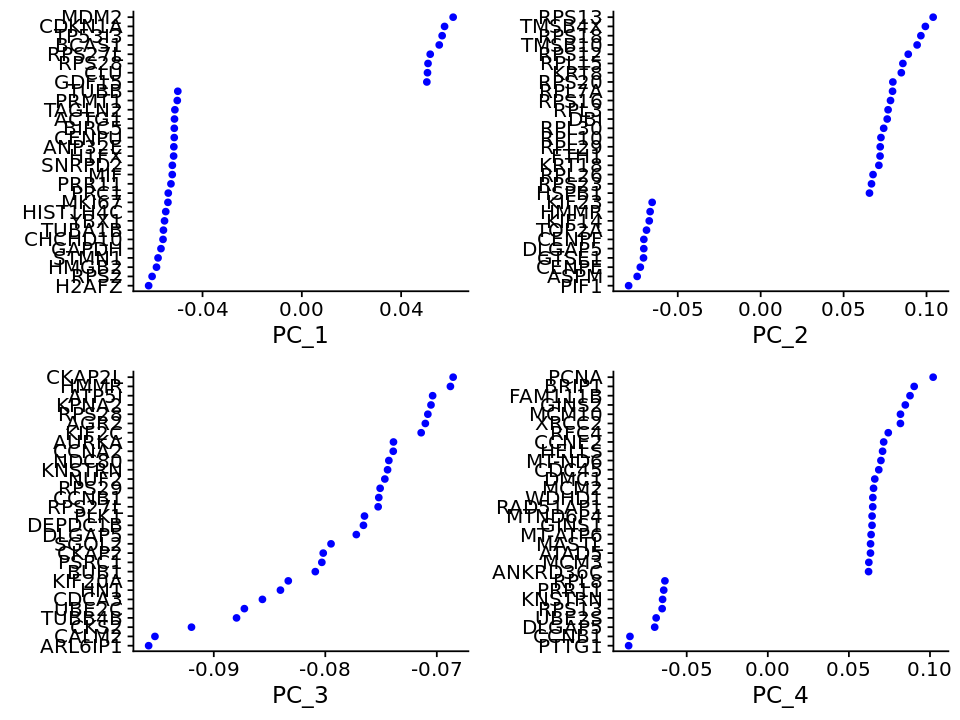

In [37]:
options(repr.plot.width=8, repr.plot.height=6)
VizDimLoadings(mcf7_seurat_obj, dims = 1:4, reduction = "pca")

The plot contains the top genes for a PC ranked by the scores absolute values.

Use `DimPlot` to plot the cells on the first two PC axes:

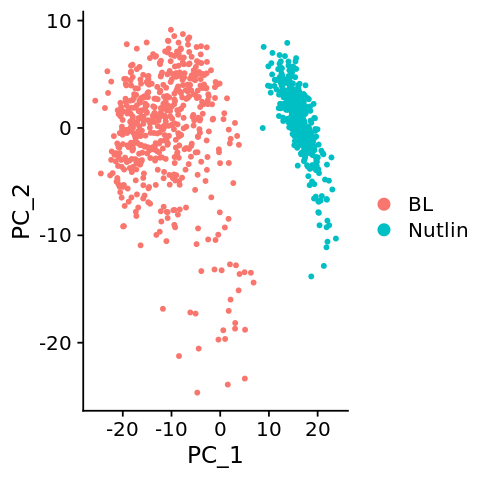

In [38]:
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(mcf7_seurat_obj, reduction = "pca", group.by = "Treatment")

This PCA plot clearly indicates that principal component 1 is associated with treatment.

Use `DimHeatmap` to visualize the PCA scores of genes and cells for one or more principal components.

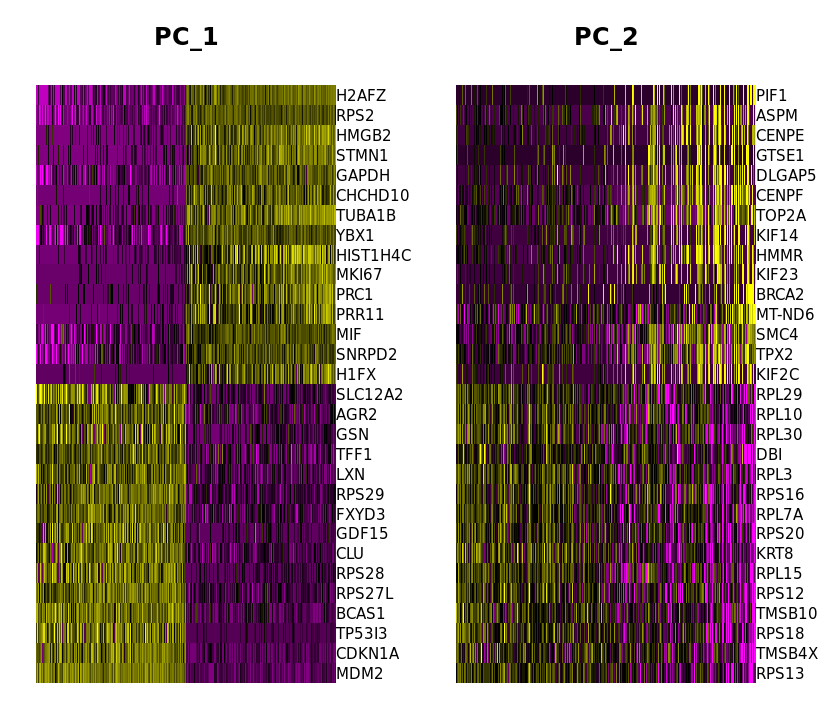

In [39]:
options(repr.plot.width=7, repr.plot.height=6)
DimHeatmap(mcf7_seurat_obj, dims = 1:2, cells = 500, balanced = TRUE)

To overcome the noise and sparsity of single-cell RNA-seq data and at the same time utilizing the high dimensionality of the data, we do not use individual genes for the clustering step but principal components (which are essentially 'meta-genes'). Therefore, it is important to determine with PCs contain enough information. There are several ways of obtaining this information.

Citing the Seurat tutorial: 

> PC selection – identifying the true dimensionality of a dataset – is an important step for Seurat, but can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly.

We will go for the third method which is the elbow-method. In this method, we look at the plot of the standard deviations of the principle components and draw the cutoff where there is a clear elbow in the graph. This can be done with `ElbowPlot`.

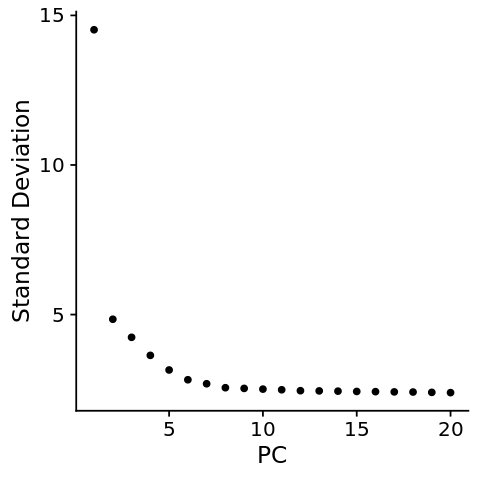

In [40]:
options(repr.plot.width=4, repr.plot.height=4)
ElbowPlot(object = mcf7_seurat_obj)

In our case, it looks like the elbow would fall around PC 9, i.e. that the first 9 PCs capture the majority of signal.
We use those 9 PCs for the following step, which finds clusters of cells that have similar expression profiles:

In [41]:
mcf7_seurat_obj <- FindNeighbors(mcf7_seurat_obj, dims = 1:9)
mcf7_seurat_obj <- FindClusters(mcf7_seurat_obj, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 916
Number of edges: 32224

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8041
Number of communities: 6
Elapsed time: 0 seconds


Note: the parameter 'resolution' sets the 'granularity' of the clustering, with increased values leading to a greater number of clusters. You can play with this parameter to find the optimal resolution for your data set.

In [42]:
# Look at cluster IDs of the first 5 cells
head(Idents(mcf7_seurat_obj), 5)

AGTATCACTATC_BL ATCTCTATGAGT_BL AGGGACCTTGAA_BL GCAGCTGGCACG_BL CCGCCTACTTAA_BL 
              2               4               0               0               0 
Levels: 0 1 2 3 4 5

By looking at the levels you can see that Seurat found six clusters of cells.

Clustering results are written in to the `@meta.data` indicating the chosen resolution in the column name.

In [43]:
head(mcf7_seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Treatment,percent.mt,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<fct>,<dbl>,<fct>,<fct>
AGTATCACTATC_BL,SeuratProject,70746,8349,BL,7.672519,2,2
ATCTCTATGAGT_BL,SeuratProject,74544,8264,BL,6.219146,4,4
AGGGACCTTGAA_BL,SeuratProject,65426,8044,BL,5.834072,0,0
GCAGCTGGCACG_BL,SeuratProject,63015,7925,BL,4.897247,0,0
CCGCCTACTTAA_BL,SeuratProject,71530,8161,BL,5.234167,0,0
CAACTAGGTGCA_BL,SeuratProject,65439,8217,BL,5.713718,0,0


### Non-linear dimensionality reduction

Two very popular non-linear dimensionality reduction methods for single-cell RNA-seq data are tSNE and UMAP.
Both algorithms map multi-dimensional data to a lower dimensional space and identify cell clusters based on similarity.

Again, we use the first 9 principal components as input because they capture most of the variability.

In [44]:
#tSNE
mcf7_seurat_obj <- RunTSNE(object = mcf7_seurat_obj, dims.use = 1:9)
#umap
mcf7_seurat_obj <- RunUMAP(mcf7_seurat_obj, dims = 1:9)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”20:56:27 UMAP embedding parameters a = 0.9922 b = 1.112
20:56:27 Read 916 rows and found 9 numeric columns
20:56:27 Using Annoy for neighbor search, n_neighbors = 30
20:56:27 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
20:56:27 Writing NN index file to temp file /tmp/Rtmp2MgbKX/file79f64ffc4121
20:56:27 Searching Annoy index using 1 thread, search_k = 3000
20:56:27 Annoy recall = 100%
20:56:27 Commencing smooth kNN distance calibration using 1 thread
20:56:28 Initializing from normalized Laplacian + noise
20:56:28 Commencing optimization 

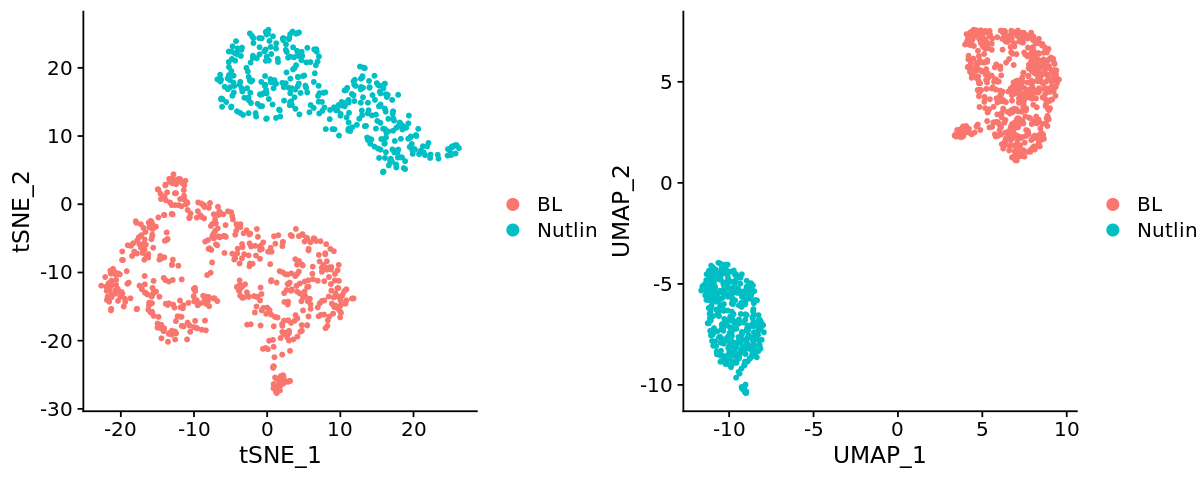

In [45]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(mcf7_seurat_obj, reduction = "tsne", group.by = "Treatment")
plot2 <- DimPlot(mcf7_seurat_obj, reduction = "umap", group.by = "Treatment")
CombinePlots(plots = list(plot1, plot2))

Both plots shows two clear clusters - associated with `Treatment`.

The cells within each of the clusters found in the previous step should co-localize on the tSNE and UMAP plots.

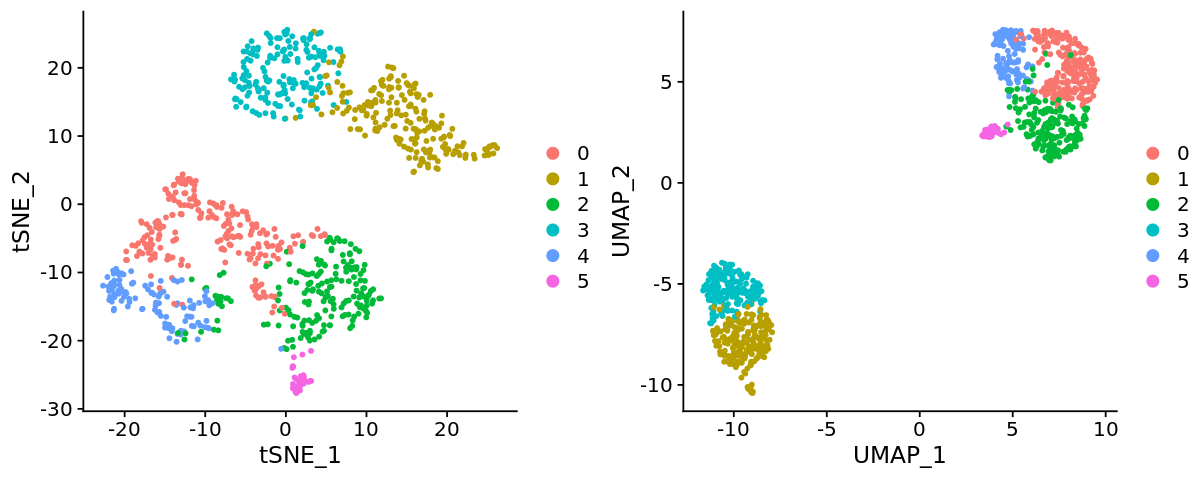

In [46]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(mcf7_seurat_obj, reduction = "tsne")
plot2 <- DimPlot(mcf7_seurat_obj, reduction = "umap")
CombinePlots(plots = list(plot1, plot2))

### Marker discovery

After having clustered the cells into subgroups, we want to characterize those clusters.
A first step is to find genes that are specific to the clusters via differential expression (we call those genes markers).

---
The Seurat function `FindAllMarkers` compares each cluster to all other cells.

By default, it identifies positive and negative markers, you can change that behaviour by setting `only.pos = TRUE`.
The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the `logfc.threshold` argument requires a feature to be differentially expressed (on average) by some amount between the two groups.

In [47]:
mcf7_markers_res0.5 <- FindAllMarkers(object = mcf7_seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
#save the markers for later
saveRDS(mcf7_markers_res0.5, file = "mcf7_markers_cluster_res0.5.rds.gz", compress = "gzip")

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5


Have a look at the top markers for each cluster:

In [48]:
mcf7_markers_res0.5 %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
9.459700e-70,0.8310099,0.977,0.588,1.296736e-65,0,DUT
5.506691e-58,1.1724884,0.991,0.671,7.548572e-54,0,HIST1H4C
2.433982e-98,1.0011590,1.000,1.000,3.336502e-94,1,MT-RNR2
1.718131e-66,1.2652217,1.000,0.814,2.355213e-62,1,MDM2
1.923844e-36,0.5859082,1.000,0.999,2.637205e-32,2,RPS2
2.759157e-33,0.5298913,0.979,0.898,3.782252e-29,2,RPL18A
1.443612e-53,1.0193872,1.000,0.710,1.978904e-49,3,CDKN1A
3.260728e-45,0.9880517,1.000,0.823,4.469805e-41,3,MDM2
2.544763e-61,1.2892939,0.991,0.505,3.488362e-57,4,CCNB1


The expression of specific genes can be visualized using `VlnPlot`, `FeaturePlot` and `DoHeatmap`:

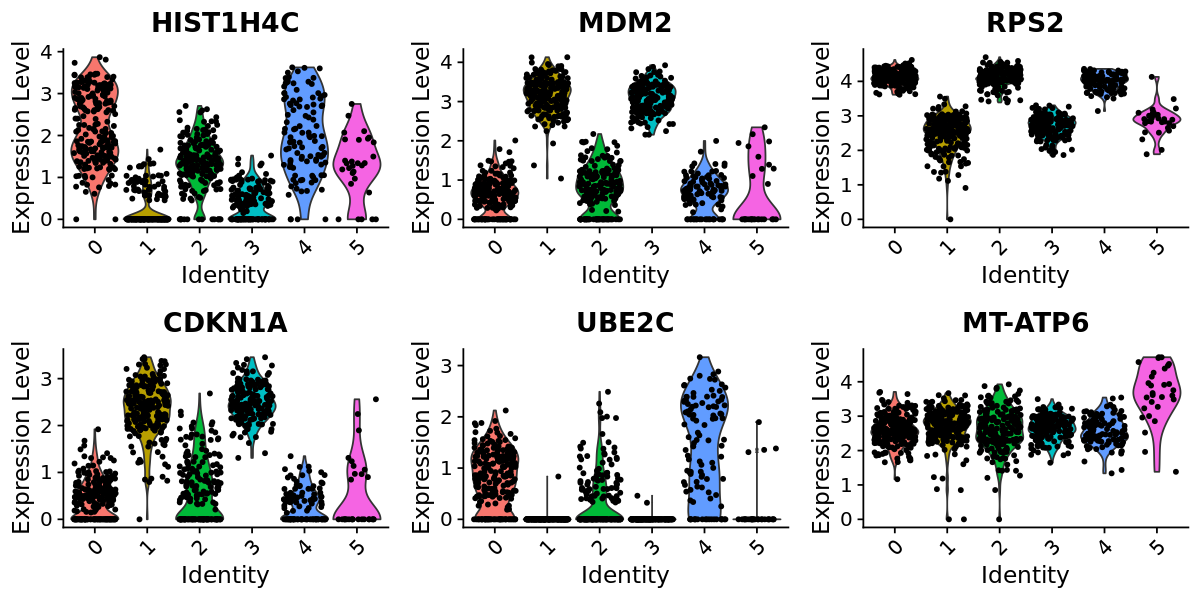

In [49]:
options(repr.plot.width=10, repr.plot.height=5)
mcf7_markers_top1 <- mcf7_markers_res0.5 %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
VlnPlot(mcf7_seurat_obj, features = mcf7_markers_top1$gene)

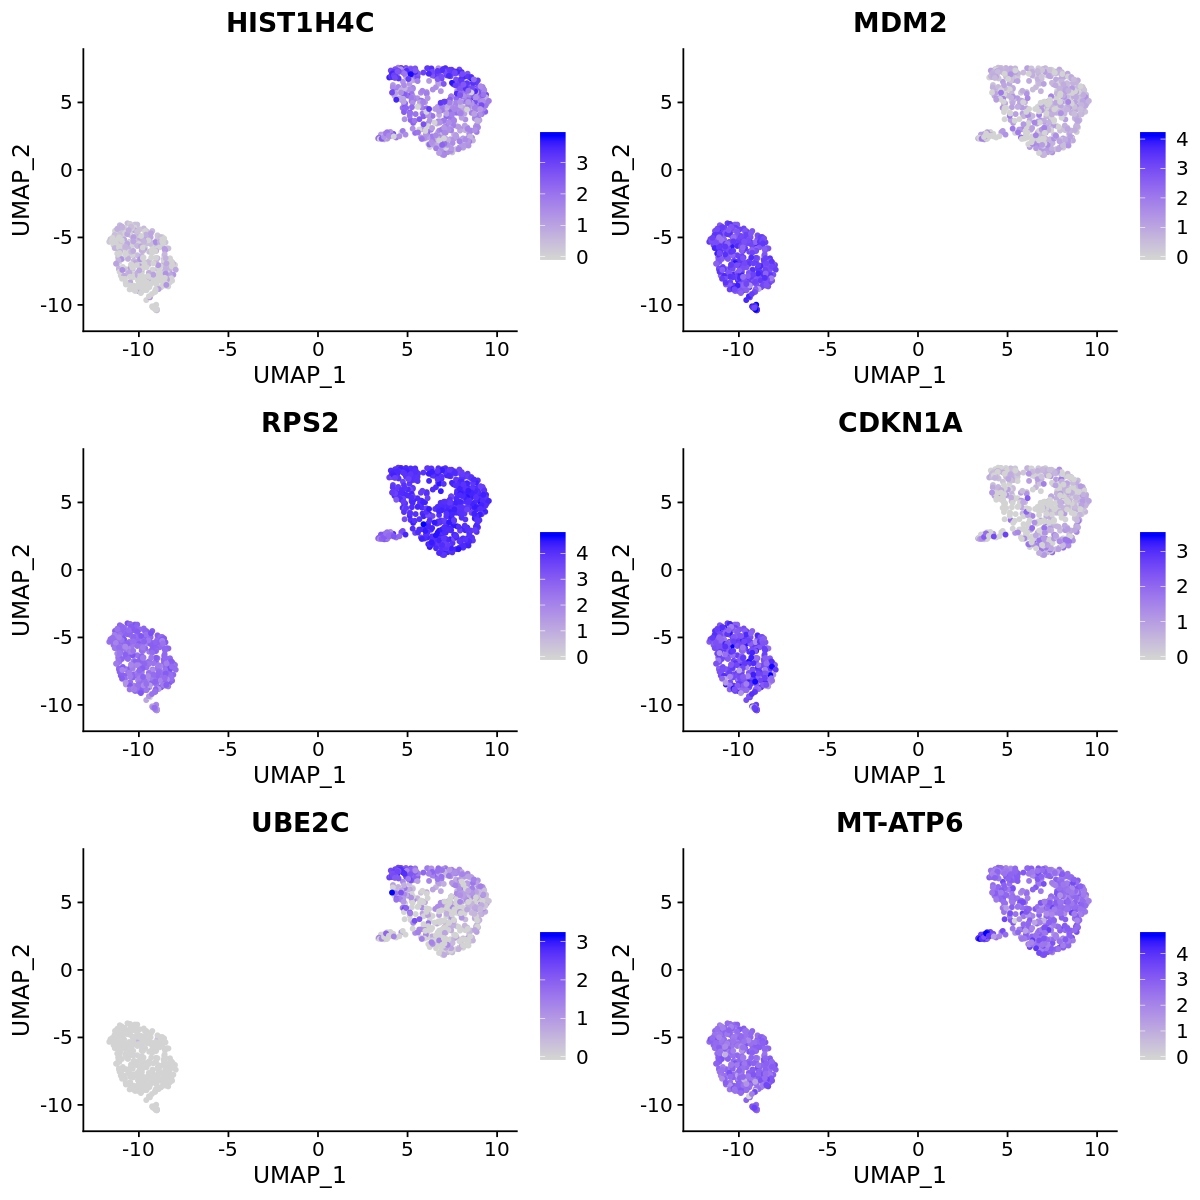

In [50]:
options(repr.plot.width=10, repr.plot.height=10)
FeaturePlot(mcf7_seurat_obj, features = mcf7_markers_top1$gene)

In [51]:
mcf7_markers_top10 <- mcf7_markers_res0.5 %>% group_by(cluster) %>% top_n(10, avg_logFC)

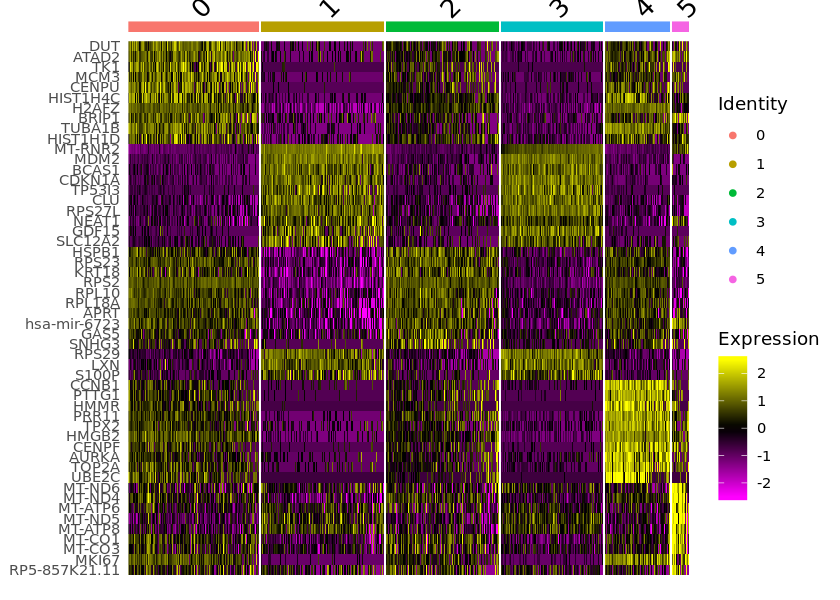

In [52]:
options(repr.plot.width=7, repr.plot.height=5)
DoHeatmap(object = mcf7_seurat_obj, features = mcf7_markers_top10$gene)

Some clusters have a very similar expression pattern of the top marker genes. The two Nutlin clusters 1 and 3 barely show any differences. Possibly, we defined too many clusters. Playing with the resolution parameter of `FindClusters` can help to find a better set of clusters.

In [53]:
mcf7_seurat_obj <- FindClusters(mcf7_seurat_obj, resolution = 0.3)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 916
Number of edges: 32224

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8600
Number of communities: 4
Elapsed time: 0 seconds


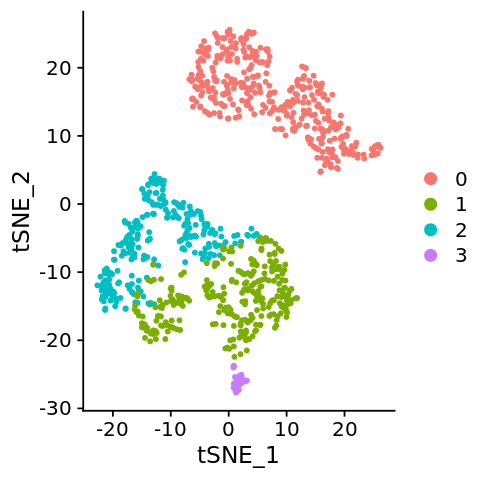

In [54]:
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(mcf7_seurat_obj, reduction = "tsne")

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3


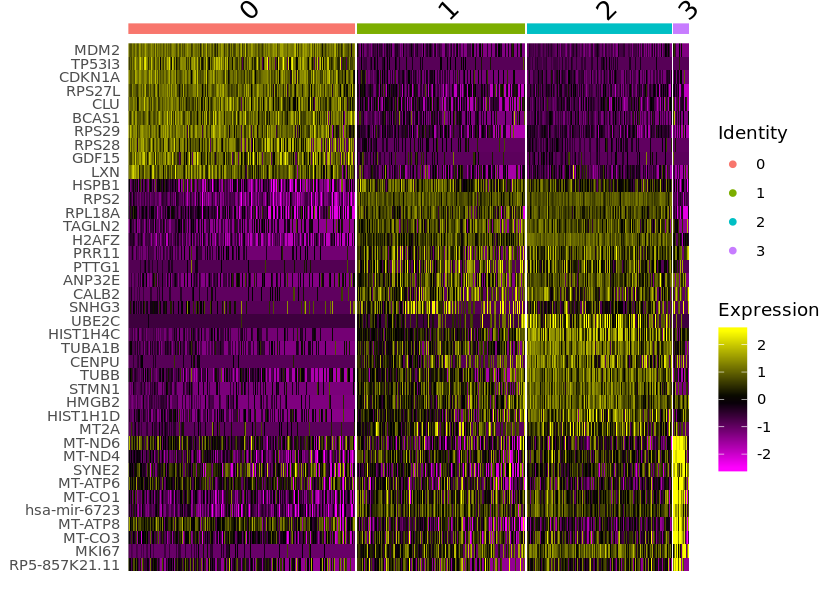

In [55]:
mcf7_markers_res0.3 <- FindAllMarkers(object = mcf7_seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(mcf7_markers_res0.3, file = "mcf7_markers_cluster_res0.3.rds.gz", compress = "gzip")

mcf7_markers_top10 <- mcf7_markers_res0.3 %>% group_by(cluster) %>% top_n(10, avg_logFC)
options(repr.plot.width=7, repr.plot.height=5)
DoHeatmap(object = mcf7_seurat_obj, features = mcf7_markers_top10$gene)

Cluster 3 looks suspicious. It contains cells of the control treatment (baseline), but has a high expression of mitochondrial genes, which can indicate bad-quality cells. Therefore, we remove this cell cluster and re-run the analysis steps.

In [56]:
mcf7_seurat_obj <- subset(mcf7_seurat_obj, ident = "3", invert = TRUE)
mcf7_seurat_obj <- RunPCA(mcf7_seurat_obj, ndims.print = 1:3, nfeatures.print = 5)
mcf7_seurat_obj <- FindNeighbors(mcf7_seurat_obj, dims = 1:9)
mcf7_seurat_obj <- FindClusters(mcf7_seurat_obj, resolution = 0.3)

PC_ 1 
Positive:  MDM2, CDKN1A, TP53I3, BCAS1, RPS27L 
Negative:  H2AFZ, RPS2, HMGB2, STMN1, GAPDH 
PC_ 2 
Positive:  KRT8, RPS18, KRT18, RPL30, RPS13 
Negative:  DLGAP5, BUB1, HMMR, UBE2C, CCNB1 
PC_ 3 
Positive:  PTTG1, PTMS, RPS2, YBX1, ANP32E 
Negative:  SPTSSB, TMSB4X, RPS29, ATP5I, RPS27L 
Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 890
Number of edges: 31936

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8596
Number of communities: 3
Elapsed time: 0 seconds


20:58:34 UMAP embedding parameters a = 0.9922 b = 1.112
20:58:34 Read 890 rows and found 9 numeric columns
20:58:34 Using Annoy for neighbor search, n_neighbors = 30
20:58:34 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
20:58:34 Writing NN index file to temp file /tmp/Rtmp2MgbKX/file79f62afe6a6d
20:58:34 Searching Annoy index using 1 thread, search_k = 3000
20:58:34 Annoy recall = 100%
20:58:35 Commencing smooth kNN distance calibration using 1 thread
20:58:35 Initializing from normalized Laplacian + noise
20:58:35 Commencing optimization for 500 epochs, with 35956 positive edges
20:58:37 Optimization finished


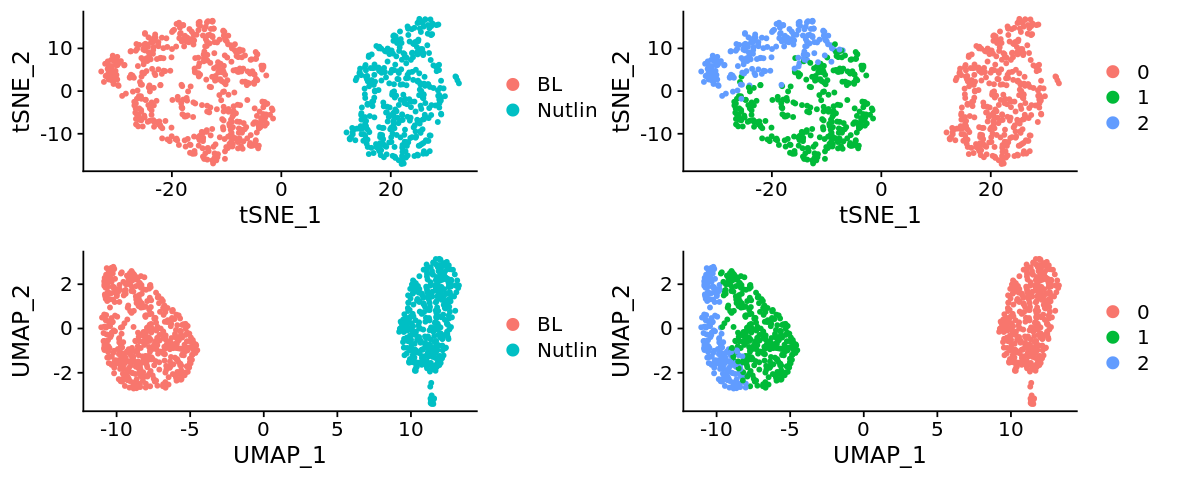

In [57]:
mcf7_seurat_obj <- RunTSNE(object = mcf7_seurat_obj, dims.use = 1:9)
mcf7_seurat_obj <- RunUMAP(mcf7_seurat_obj, dims = 1:9)
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(mcf7_seurat_obj, reduction = "tsne", group.by = "Treatment")
plot2 <- DimPlot(mcf7_seurat_obj, reduction = "tsne")
plot3 <- DimPlot(mcf7_seurat_obj, reduction = "umap", group.by = "Treatment")
plot4 <- DimPlot(mcf7_seurat_obj, reduction = "umap")

CombinePlots(plots = list(plot1, plot2, plot3, plot4))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


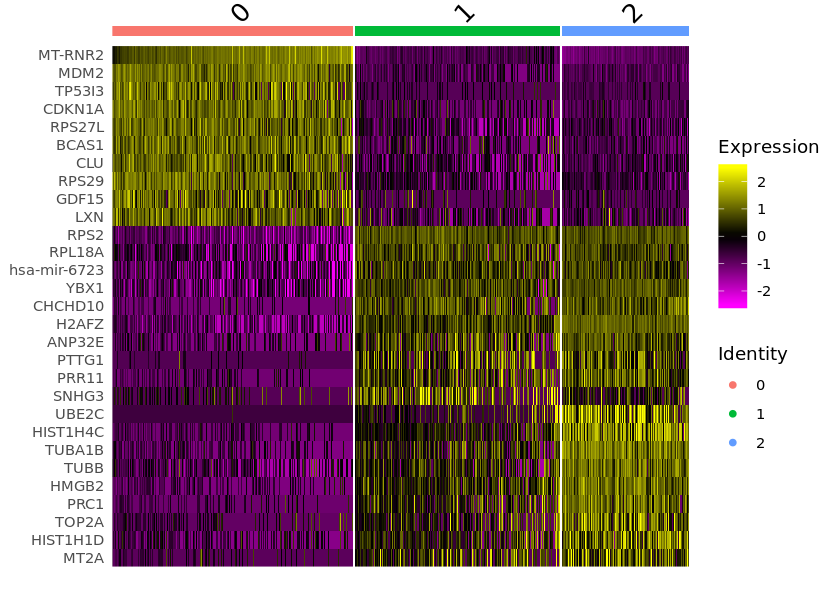

In [58]:
mcf7_markers_res0.3 <- FindAllMarkers(object = mcf7_seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(mcf7_markers_res0.3, file = "mcf7_markers_cluster_res0.3.rds.gz", compress = "gzip")

options(repr.plot.width=7, repr.plot.height=5)
mcf7_markers_top10 <- mcf7_markers_res0.3 %>% group_by(cluster) %>% top_n(10, avg_logFC)
DoHeatmap(object = mcf7_seurat_obj, features = mcf7_markers_top10$gene)

Clusters 1 and 2 with cells belonging to the control treatment have similar gene expression, when compared to the Nutlin cell cluster, but there are small differences. To find markers that distinguish those two clusters, we can calculate differential gene expression by contrasting those two clusters only:

In [59]:
mcf7_markers_cl1 <- FindMarkers(mcf7_seurat_obj, ident.1 = 1, ident.2 = 2, 
                                 only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
mcf7_markers_cl1 <- mcf7_markers_cl1[order(mcf7_markers_cl1$avg_logFC, decreasing = T),]
mcf7_markers_cl2 <- FindMarkers(mcf7_seurat_obj, ident.1 = 2, ident.2 = 1, 
                                 only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
mcf7_markers_cl2 <- mcf7_markers_cl2[order(mcf7_markers_cl2$avg_logFC, decreasing = T),]
top_markers_cl1_cl2 <- c(rownames(mcf7_markers_cl1)[1:10], rownames(mcf7_markers_cl2)[1:10])

Warning message in DoHeatmap(object = mcf7_seurat_obj, features = top_markers_cl1_cl2):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: NA”

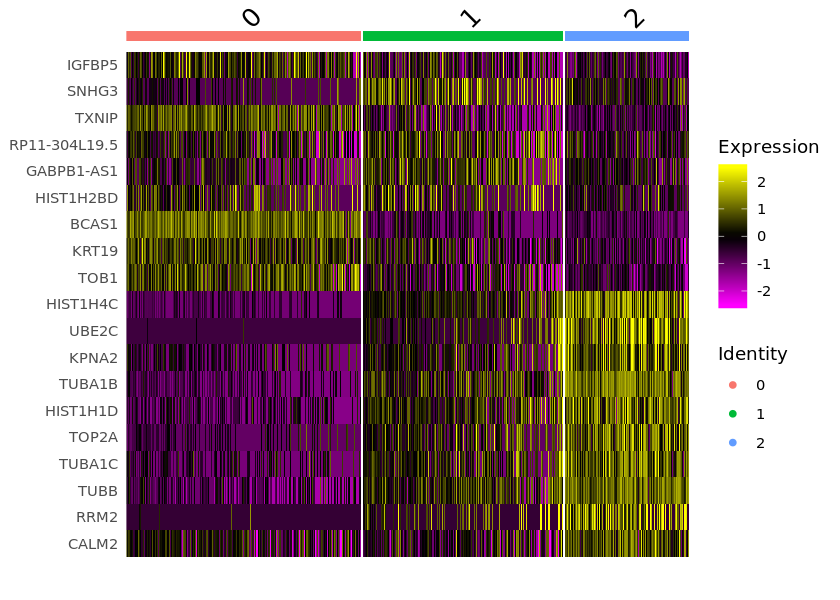

In [60]:
DoHeatmap(object = mcf7_seurat_obj, features = top_markers_cl1_cl2)

For some downstream analysis tools (such as GSEA and GOrilla), you might need ranked lists of genes instead of gene sets. You can calculate them as follows (this step will take a while!):

In [61]:
mcf7_markers_all_genes <- FindAllMarkers(mcf7_seurat_obj, 
                                         only.pos = F, 
                                         min.pct = 0, 
                                         logfc.threshold = 0, 
                                         return.thresh = 1)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


Retrieve the ranking for each cluster and save as txt files:

In [62]:
mcf7_markers_cluster_0 <- subset(mcf7_markers_all_genes, cluster == 0, select=c("avg_logFC"))
mcf7_markers_cluster_1 <- subset(mcf7_markers_all_genes, cluster == 1, select=c("avg_logFC"))
mcf7_markers_cluster_2 <- subset(mcf7_markers_all_genes, cluster == 2, select=c("avg_logFC"))

write.table(mcf7_markers_cluster_0, file = "mcf7_markers_cluster_0.txt", sep = "\t", quote = F, col.names = F)
write.table(mcf7_markers_cluster_1, file = "mcf7_markers_cluster_1.txt", sep = "\t", quote = F, col.names = F)
write.table(mcf7_markers_cluster_2, file = "mcf7_markers_cluster_2.txt", sep = "\t", quote = F, col.names = F)

Save your Seurat object as a R Data object that you can re-load for further analyses.

In [66]:
saveRDS(mcf7_seurat_obj, file = "mcf7_seurat_obj.rds.gz", compress = "gzip")

### Converting a Seurat object to a loom file 

For visualization and data exploration, you can upload this data set to [SCope](http://scope-mirror.aertslab.org/).

Therefore, you need to create a loom file that contains the following data from your Seurat object:
* the raw count matrix 
* known cell information / annotation
* PCA, tSNE and/or UMAP coordinates

In [73]:
mcf7_loom <- build_loom(file.name = "mcf7_seurat_obj.loom", 
                        dgem = as.matrix(mcf7_seurat_obj[["RNA"]]@counts), 
                        title = "MCF7 Nutlin",
                        genome = "Human",
                        default.embedding = mcf7_seurat_obj@reductions$tsne@cell.embeddings,
                        default.embedding.name = "tSNE on variable genes")

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns edges..."
[1] "Adding row edges..."
[1] "Adding layers..."


In [74]:
add_col_attr(mcf7_loom, key = "percent.mito", 
                 value = mcf7_seurat_obj@meta.data$percent.mt, 
                 as.metric = T)

In [75]:
add_col_attr(mcf7_loom, key = "Treatment",
                value = as.vector(mcf7_seurat_obj@meta.data$Treatment),
                as.annotation = T)

In [76]:
marker_file_list <- list(
    RNA_snn_res.0.5 = "mcf7_markers_cluster_res0.5.rds.gz",
    RNA_snn_res.0.3 = "mcf7_markers_cluster_res0.3.rds.gz")

add_seurat_clustering(mcf7_loom, 
                      seurat = mcf7_seurat_obj,
                      seurat.assay = "RNA",
                      default.clustering.resolution = 0.3,
                      seurat.clustering.prefix = "RNA_snn_res.",
                      seurat.markers.file.path.list = marker_file_list)

[1] "Seurat, RNA_snn_res.0.5"
[1] "Adding Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Seurat, RNA_snn_res.0.3"
[1] "Adding Seurat clusters..."
[1] "Adding default Seurat clusters..."
[1] "Clusterings already exists..."
[1] "Clustering ID: 1"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 1..."


In [ ]:
finalize(mcf7_loom)

Now you can transfer this loom file to your computer, go to http://scope-mirror.aertslab.org/ (via Firefox or Chrome) and upload  the loom file. 
It should appear under `Uncategorized` section - if it does not appear there, it means that your loom file is corrupt (either damaged during transfer [so re-copy it from the server] or there was an error in `build_loom` step [check your command]).

On SCope, you can check the expression of individual genes:

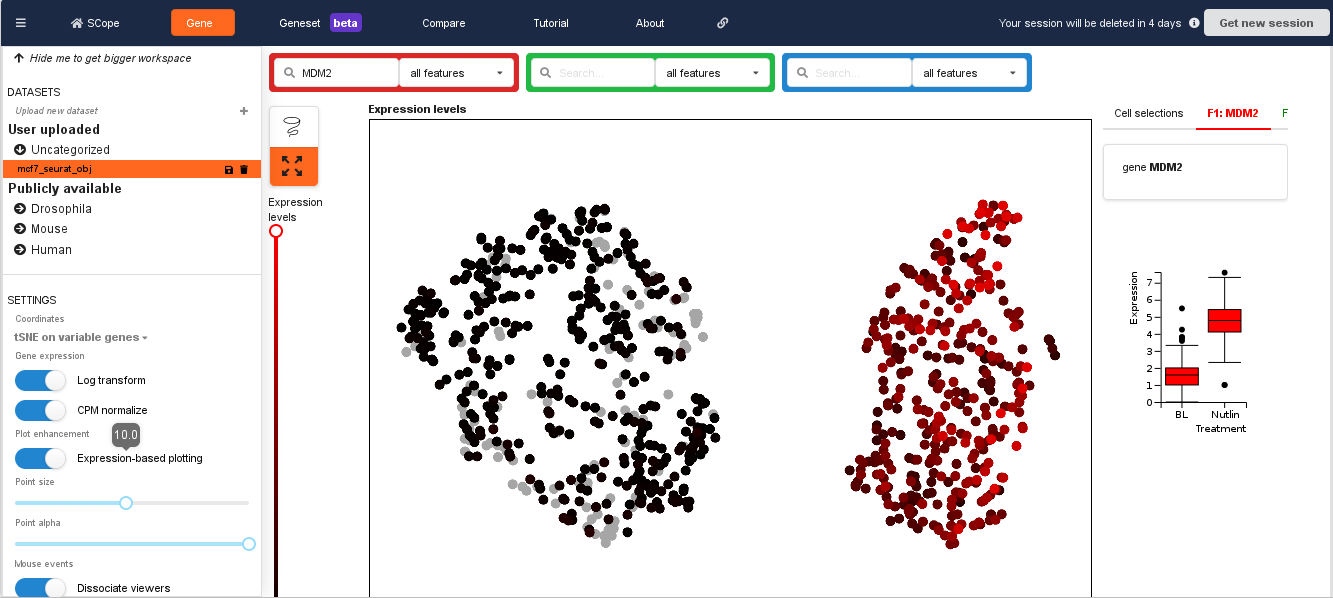

In [91]:
IRdisplay::display_png(file = "/mnt/storage/data/dropseq/scope_screenshots/gene_expr1.png")

display meta data:

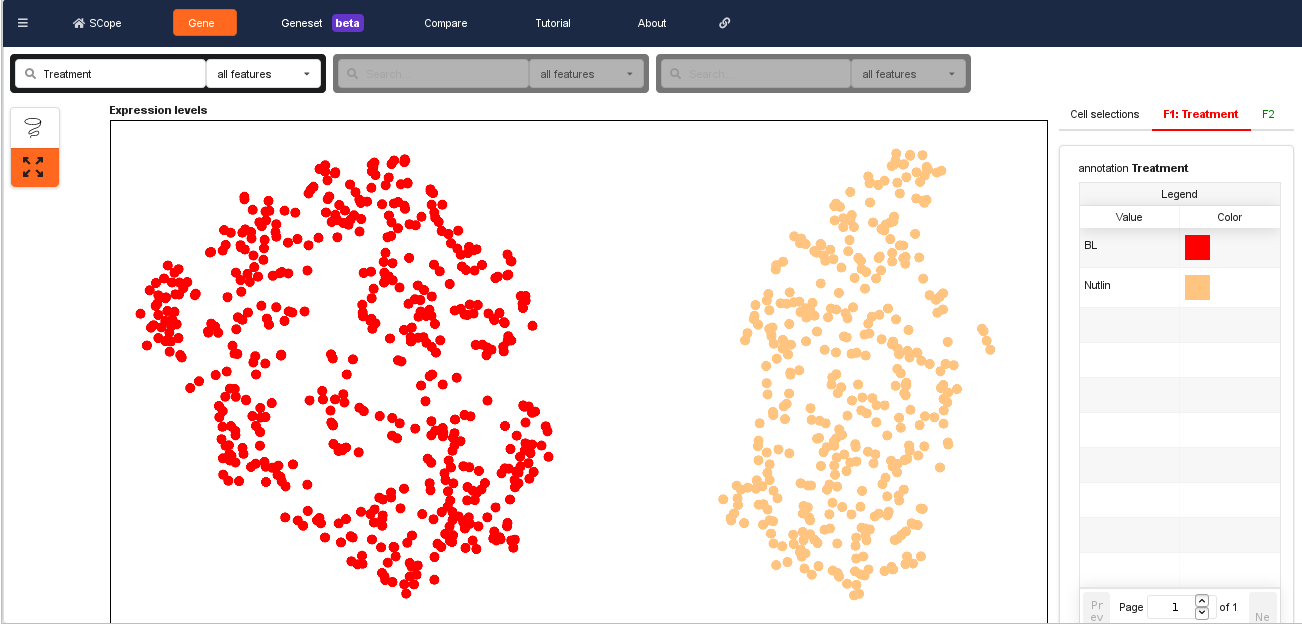

In [92]:
IRdisplay::display_png(file = "/mnt/storage/data/dropseq/scope_screenshots/treatment1.png")

inspect clusters and their marker genes, annotate clusters:

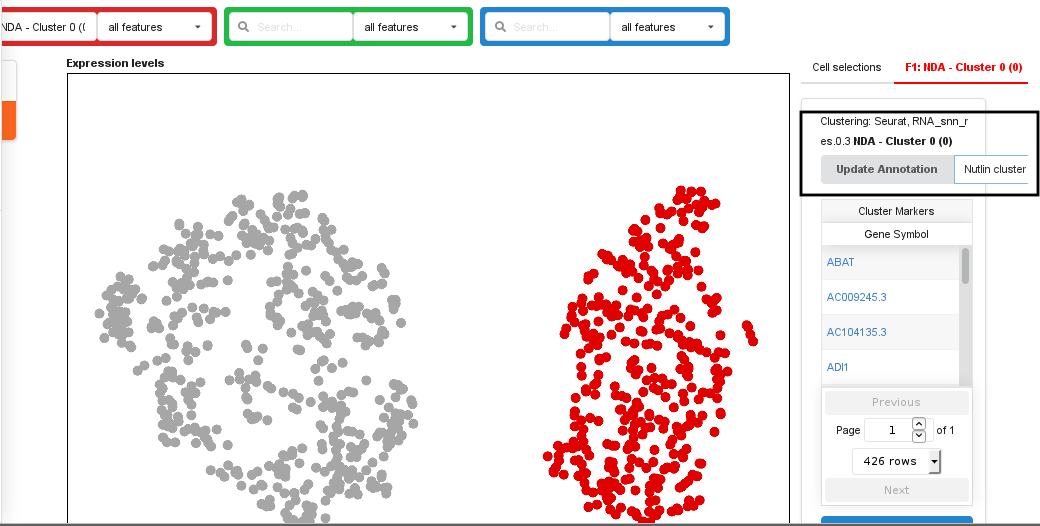

In [93]:
IRdisplay::display_png(file = "/mnt/storage/data/dropseq/scope_screenshots/rename_cluster1.png")

When you analyze your own dataset, use screenshots to document your SCope results in the jupyter notebook.

### Word of warning - careful with what you normalize

Normalization is done for removing (technical) bias in your data - however you must make sure what is commonly treated as technical bias is not associated with the biological phenomenon you're investigating. 

Filtering or scaling for mitochondrial genes is a common practice in scRNA-seq analysis. In our case, we have observed a bimodal distribution for mitochondrial gene expression, and this bimodality was associated with our treatment. 

Let's see what happens if we treat mitochondrial gene expression as a technical bias in our dataset.

In [94]:
mcf7_m_seurat_obj <- mcf7_seurat_obj
mcf7_m_seurat_obj <- ScaleData(object = mcf7_m_seurat_obj, vars.to.regress = c("nUMI", "percent.mt"))

Regressing out nUMI, percent.mt
Centering and scaling data matrix


In [95]:
mcf7_m_seurat_obj <- RunPCA(mcf7_m_seurat_obj, ndims.print = 1:3, nfeatures.print = 5)
mcf7_m_seurat_obj <- FindNeighbors(mcf7_m_seurat_obj, dims = 1:9)
mcf7_m_seurat_obj <- FindClusters(mcf7_m_seurat_obj, resolution = 0.3)

PC_ 1 
Positive:  MDM2, CDKN1A, RPS27L, TP53I3, GDF15 
Negative:  HMGB2, H2AFZ, STMN1, MKI67, TUBA1B 
PC_ 2 
Positive:  RPS2, KRT18, KRT8, RPL8, hsa-mir-6723 
Negative:  DLGAP5, CCNB1, HMMR, AURKA, BUB1 
PC_ 3 
Positive:  PTTG1, RPS2, PRR11, RAD21, HMGB2 
Negative:  CDKN1A, FXYD3, BCAS1, RPS29, RPS27L 
Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 890
Number of edges: 30794

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8131
Number of communities: 4
Elapsed time: 0 seconds


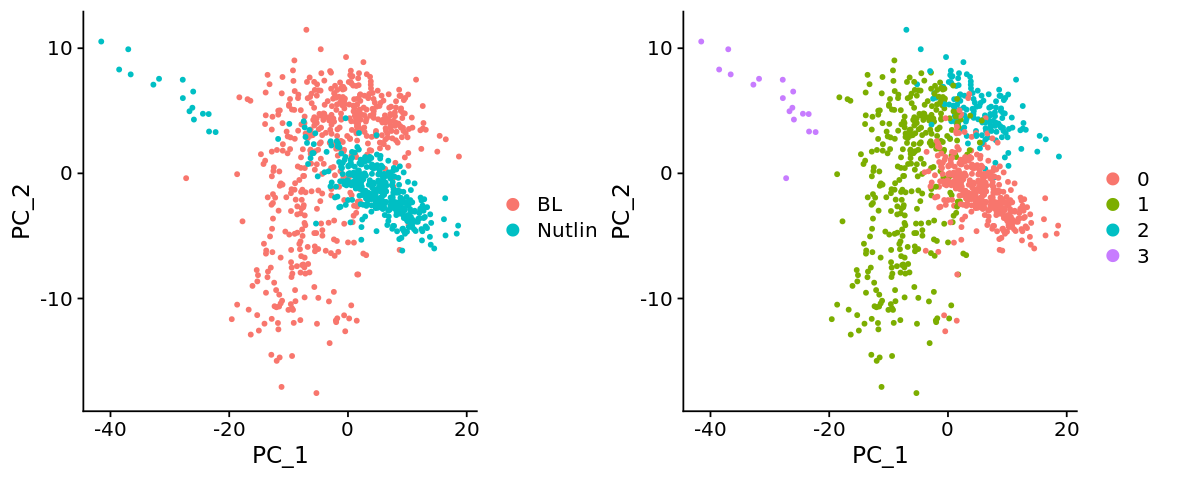

In [96]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(mcf7_m_seurat_obj, reduction = "pca", group.by="Treatment")
plot2 <- DimPlot(mcf7_m_seurat_obj, reduction = "pca")
CombinePlots(plots = list(plot1, plot2))

13:16:47 UMAP embedding parameters a = 0.9922 b = 1.112
13:16:47 Read 890 rows and found 9 numeric columns
13:16:47 Using Annoy for neighbor search, n_neighbors = 30
13:16:47 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
13:16:47 Writing NN index file to temp file /tmp/RtmpFdNzJV/fileea511b826ac
13:16:47 Searching Annoy index using 1 thread, search_k = 3000
13:16:47 Annoy recall = 100%
13:16:48 Commencing smooth kNN distance calibration using 1 thread
13:16:48 Initializing from normalized Laplacian + noise
13:16:48 Commencing optimization for 500 epochs, with 35416 positive edges
13:16:50 Optimization finished


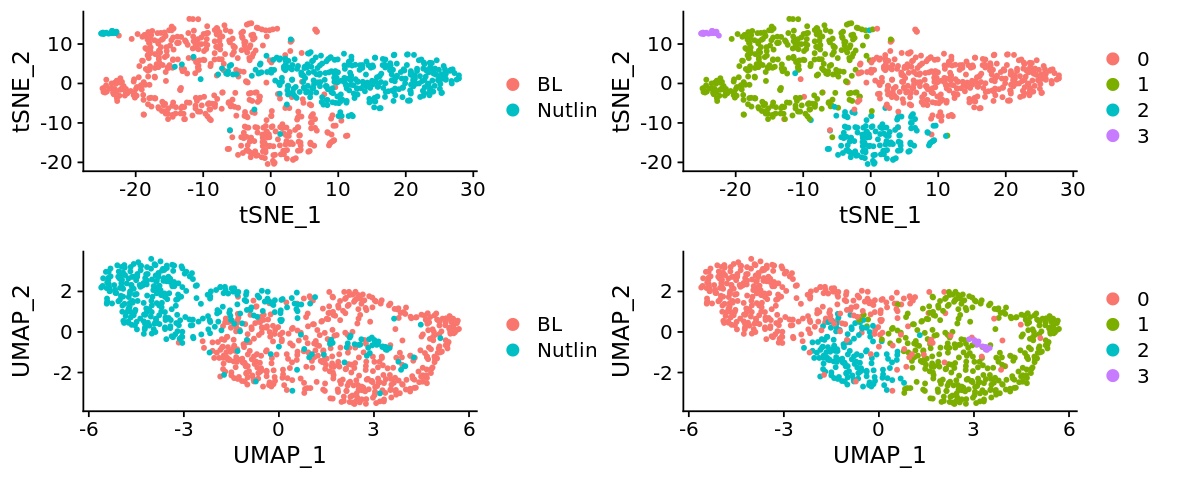

In [97]:
mcf7_m_seurat_obj <- RunTSNE(object = mcf7_m_seurat_obj,  dims = 1:9)
mcf7_m_seurat_obj <- RunUMAP(object = mcf7_m_seurat_obj,  dims = 1:9)

options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(mcf7_m_seurat_obj, reduction = "tsne", group.by="Treatment")
plot2 <- DimPlot(mcf7_m_seurat_obj, reduction = "tsne")
plot3 <- DimPlot(mcf7_m_seurat_obj, reduction = "umap", group.by="Treatment")
plot4 <- DimPlot(mcf7_m_seurat_obj, reduction = "umap")
CombinePlots(plots = list(plot1, plot2, plot3, plot4))

Now check the expression of CDKN1A & MDM2 on the tSNE:

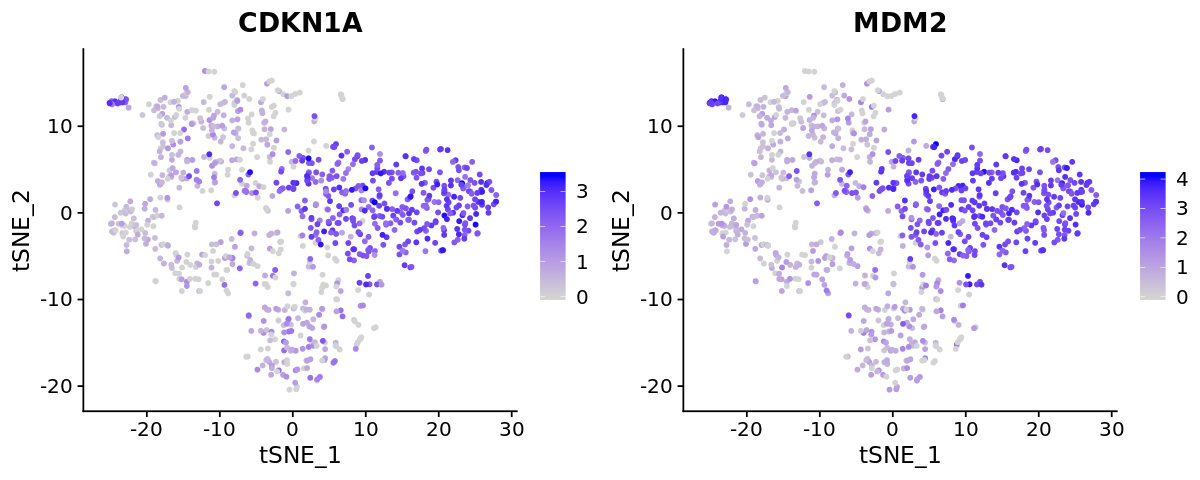

In [98]:
FeaturePlot(object = mcf7_m_seurat_obj, 
            features = c("CDKN1A", "MDM2"),
            reduction = "tsne")

There is no clear separation any more of cells belonging to the treatment and the control, respectively.
So by scaling our data with mitochondrial expression we lost Nutlin stimulation effect. 


REF: [Nutlin and mitochondria](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3613239/) 

### And before you close your notebook...

If you want to exchange code with others or be able to reproduce your own results, it is a good idea to document the versions of R, the packages you have been using and some system properties

In [99]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] IRdisplay_0.7.0  SCopeLoomR_0.5.0 Matrix_1.2-17    dplyr_0.8.3     
[5] Seurat_3.1.0    

loaded via a namespace (and not attached):
  [1] tsne_0.1-3          nlme_3.1-141        bitops_1.0-6       
  [4] bit64_0.9-7         RcppAnnoy_0.0.13    RColorBrewer_1.1-2 